In [1]:
import tensorflow as tf
import gc
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, Activation, BatchNormalization, Dropout, LSTM, ConvLSTM2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input,Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation, LSTM, ConvLSTM2D, Lambda, Reshape, BatchNormalization, Bidirectional
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint,TensorBoard,TerminateOnNaN, LearningRateScheduler, CSVLogger
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
from tensorflow.keras.layers import Lambda, Reshape, DepthwiseConv2D, ZeroPadding2D, Add, MaxPooling2D,Activation, Flatten, Conv2D, Dense, Input, Dropout, Concatenate, GlobalMaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers.experimental import preprocessing
from keras.applications import imagenet_utils
from tensorflow.keras import layers
!pip install tensorflow-addons
import tensorflow_addons as tfa
import pandas as pd
import numpy as np
import random
import keras
import shutil
import pathlib
import cv2
import os
import matplotlib.image as mpimg
import seaborn as sns
print(tf.__version__)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 23.4 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


2.12.0


In [2]:
!nvidia-smi

Tue Jul 18 03:18:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train_dir = '/content/drive/MyDrive/Eye Disease Classification/DATASET/Preprocessed/train'
for dirpath, dirnames, filenames in os.walk(train_dir):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 4 directories and 0 images in '/content/drive/MyDrive/Eye Disease Classification/DATASET/Preprocessed/train'.
There are 0 directories and 400 images in '/content/drive/MyDrive/Eye Disease Classification/DATASET/Preprocessed/train/cataract'.
There are 0 directories and 400 images in '/content/drive/MyDrive/Eye Disease Classification/DATASET/Preprocessed/train/amd'.
There are 0 directories and 400 images in '/content/drive/MyDrive/Eye Disease Classification/DATASET/Preprocessed/train/normal'.
There are 0 directories and 400 images in '/content/drive/MyDrive/Eye Disease Classification/DATASET/Preprocessed/train/diabetes'.


In [5]:
test_dir = '/content/drive/MyDrive/Eye Disease Classification/DATASET/Preprocessed/valid'
for dirpath, dirnames, filenames in os.walk(test_dir):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 4 directories and 0 images in '/content/drive/MyDrive/Eye Disease Classification/DATASET/Preprocessed/valid'.
There are 0 directories and 100 images in '/content/drive/MyDrive/Eye Disease Classification/DATASET/Preprocessed/valid/cataract'.
There are 0 directories and 100 images in '/content/drive/MyDrive/Eye Disease Classification/DATASET/Preprocessed/valid/normal'.
There are 0 directories and 100 images in '/content/drive/MyDrive/Eye Disease Classification/DATASET/Preprocessed/valid/amd'.
There are 0 directories and 100 images in '/content/drive/MyDrive/Eye Disease Classification/DATASET/Preprocessed/valid/diabetes'.


In [6]:
def view_random_image(target_dir, target_class):
  target_folder = target_dir+target_class
  random_image = random.sample(os.listdir(target_folder), 1)
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");
  print(f"Image shape: {img.shape}")
  return img

Image shape: (1749, 1893, 3)


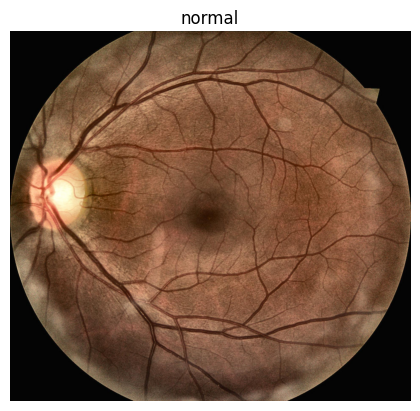

In [7]:
img = view_random_image(target_dir="/content/drive/MyDrive/Eye Disease Classification/DATASET/Preprocessed/train/",
                        target_class="normal")

In [8]:
EPOCHS = 100
from math import floor
N_FOLDS = 5
INIT_LR = 1e-3
T_BS = 16
V_BS = 16
decay_rate = 0.95
decay_step = 1
IMAGE_SIZE = [224,224]

In [9]:
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2),
  # preprocessing.Rescaling(1./255)
], name="data_augmentation")

In [10]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 label_mode="categorical",
                                                                 batch_size=32,
                                                                 image_size=IMAGE_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMAGE_SIZE,
                                                                shuffle=False)

Found 1600 files belonging to 4 classes.
Found 400 files belonging to 4 classes.


In [11]:
base_model = tf.keras.applications.InceptionResNetV2(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs)
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x)
outputs = layers.Dense(len(train_data.class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)

219055592/219055592 [==============================] - 10s 0us/step


In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 inception_resnet_v2 (Functi  (None, None, None, 1536)  54336736 
 onal)                                                           
                                                                 
 global_average_pooling (Glo  (None, 1536)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 4)                 6148      
                                                                 
Total params: 54,342,884
Trainable params: 6,148
Non-trainable params: 54,336,736
_________________________________________________________________


In [13]:
opt = Adam(learning_rate=1e-3)
model.compile(optimizer=opt,
              loss="categorical_crossentropy",
              metrics=[keras.metrics.CategoricalAccuracy(name="accuracy")])

In [14]:
checkpoint = [ModelCheckpoint(filepath='best_model.h5',
                              monitor='val_accuracy',
                              mode='max',
                              verbose=1,
                              save_best_only=True,
                              save_weights_only=True)]

In [15]:
history = model.fit(train_data,
                    epochs=EPOCHS,
                    validation_data=test_data,
                    validation_steps=len(test_data),
                    callbacks=[checkpoint])

Epoch 1/100
50/50 [==============================] - ETA: 0s - loss: 39.2405 - accuracy: 0.2744 
Epoch 1: val_accuracy improved from -inf to 0.36000, saving model to best_model.h5
50/50 [==============================] - 812s 14s/step - loss: 39.2405 - accuracy: 0.2744 - val_loss: 8.9235 - val_accuracy: 0.3600
Epoch 2/100
50/50 [==============================] - ETA: 0s - loss: 9.1513 - accuracy: 0.3288
Epoch 2: val_accuracy did not improve from 0.36000
50/50 [==============================] - 28s 506ms/step - loss: 9.1513 - accuracy: 0.3288 - val_loss: 7.1340 - val_accuracy: 0.3450
Epoch 3/100
50/50 [==============================] - ETA: 0s - loss: 13.9725 - accuracy: 0.3113
Epoch 3: val_accuracy did not improve from 0.36000
50/50 [==============================] - 28s 515ms/step - loss: 13.9725 - accuracy: 0.3113 - val_loss: 6.7626 - val_accuracy: 0.3275
Epoch 4/100
50/50 [==============================] - ETA: 0s - loss: 10.9902 - accuracy: 0.3150
Epoch 4: val_accuracy improved fro

In [16]:
model.load_weights('/content/best_model.h5')
_, accuracy = model.evaluate(test_data)
print(f"Validation accuracy: {round(accuracy * 100, 2)}%")

13/13 [==============================] - 6s 475ms/step - loss: 3.1508 - accuracy: 0.5200
Validation accuracy: 52.0%


In [17]:
pred_probs = model.predict(test_data, verbose=1)

13/13 [==============================] - 10s 547ms/step


In [18]:
pred_classes = pred_probs.argmax(axis=1)

y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())

In [19]:
target_names = ['Amd', 'Cataract', 'Diabetes','Normal']
print(classification_report(y_labels,
                            pred_classes,
                            target_names=target_names, digits=4))

              precision    recall  f1-score   support

         Amd     0.4783    0.5500    0.5116       100
    Cataract     0.6396    0.7100    0.6730       100
    Diabetes     0.4375    0.1400    0.2121       100
      Normal     0.4789    0.6800    0.5620       100

    accuracy                         0.5200       400
   macro avg     0.5086    0.5200    0.4897       400
weighted avg     0.5086    0.5200    0.4897       400



In [20]:
cm = confusion_matrix(y_labels,pred_classes)

TP = cm[0, 0]
TN = cm[1:, 1:].sum()
FP = cm[0, 1:].sum()
FN = cm[1:, 0].sum()

Population = TN+FN+TP+FP
spesificity = TN / (TN + FP)
sensitivity = TP / (TP + FN)

print("True Positives:", TP)
print("False Positives:", FP)
print("True Negatives:", TN)
print("False Negatives:", FN)
print("Spesificity:", spesificity)
print("Sensitivity:", sensitivity)

True Positives: 55
False Positives: 45
True Negatives: 240
False Negatives: 60
Spesificity: 0.8421052631578947
Sensitivity: 0.4782608695652174


In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(20, 20), text_size=15, norm=False, savefig=False):

  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
  n_classes = cm.shape[0]

  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues)
  fig.colorbar(cax)

  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes),
         yticks=np.arange(n_classes),
         xticklabels=labels,
         yticklabels=labels)

  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  threshold = (cm.max() + cm.min()) / 2.

  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

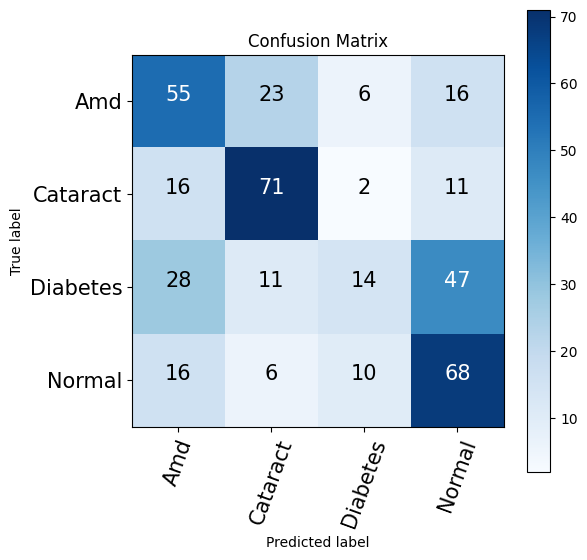

In [22]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=target_names,
                      figsize=(6, 6),
                      text_size=15,
                      norm=False,
                      savefig=True)

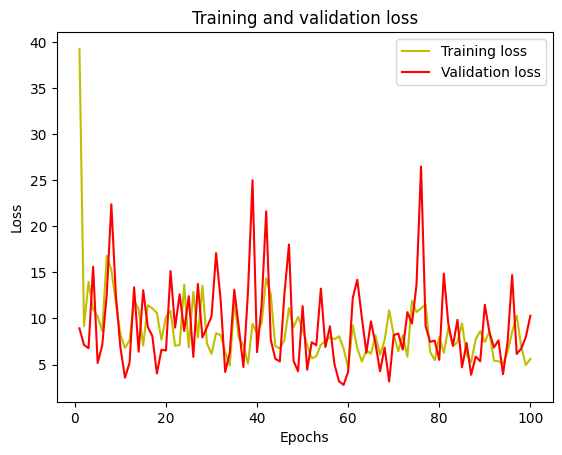

In [23]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

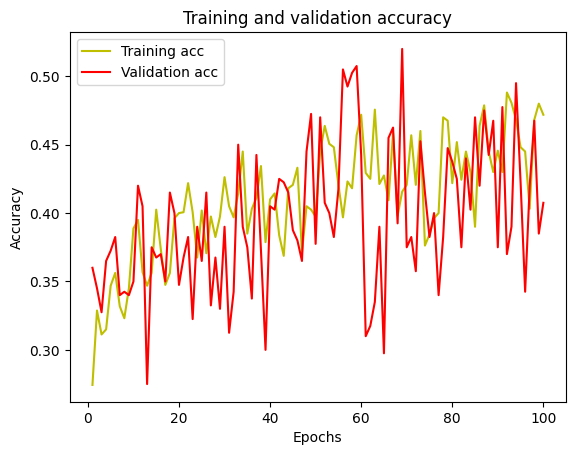

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()